# ByoTrack fundamental features

## Loading a video 

In [1]:
import matplotlib.pyplot as plt
import cv2

from byotrack import Video, VideoTransformConfig

TEST = True  # Set to False to analyze a whole video

video_path = "path/to/video.ext"
icy_path = "path/to/icy_dir/"

In [2]:
# Simply open a video
video = Video(video_path)

fps = 20
# fps = video.reader.fps

# Note: video could also be a 4 dimensionnal numpy array

In [3]:
# A transform can be added to normalize and aggregate channels

transform_config = VideoTransformConfig(aggregate=True, normalize=True, q_min=0.01, q_max=0.999)
video.set_transform(transform_config)

# Show the min max value used to clip and normalize
print(video._normalizer.mini, video._normalizer.maxi)

[1577.] [2211.]


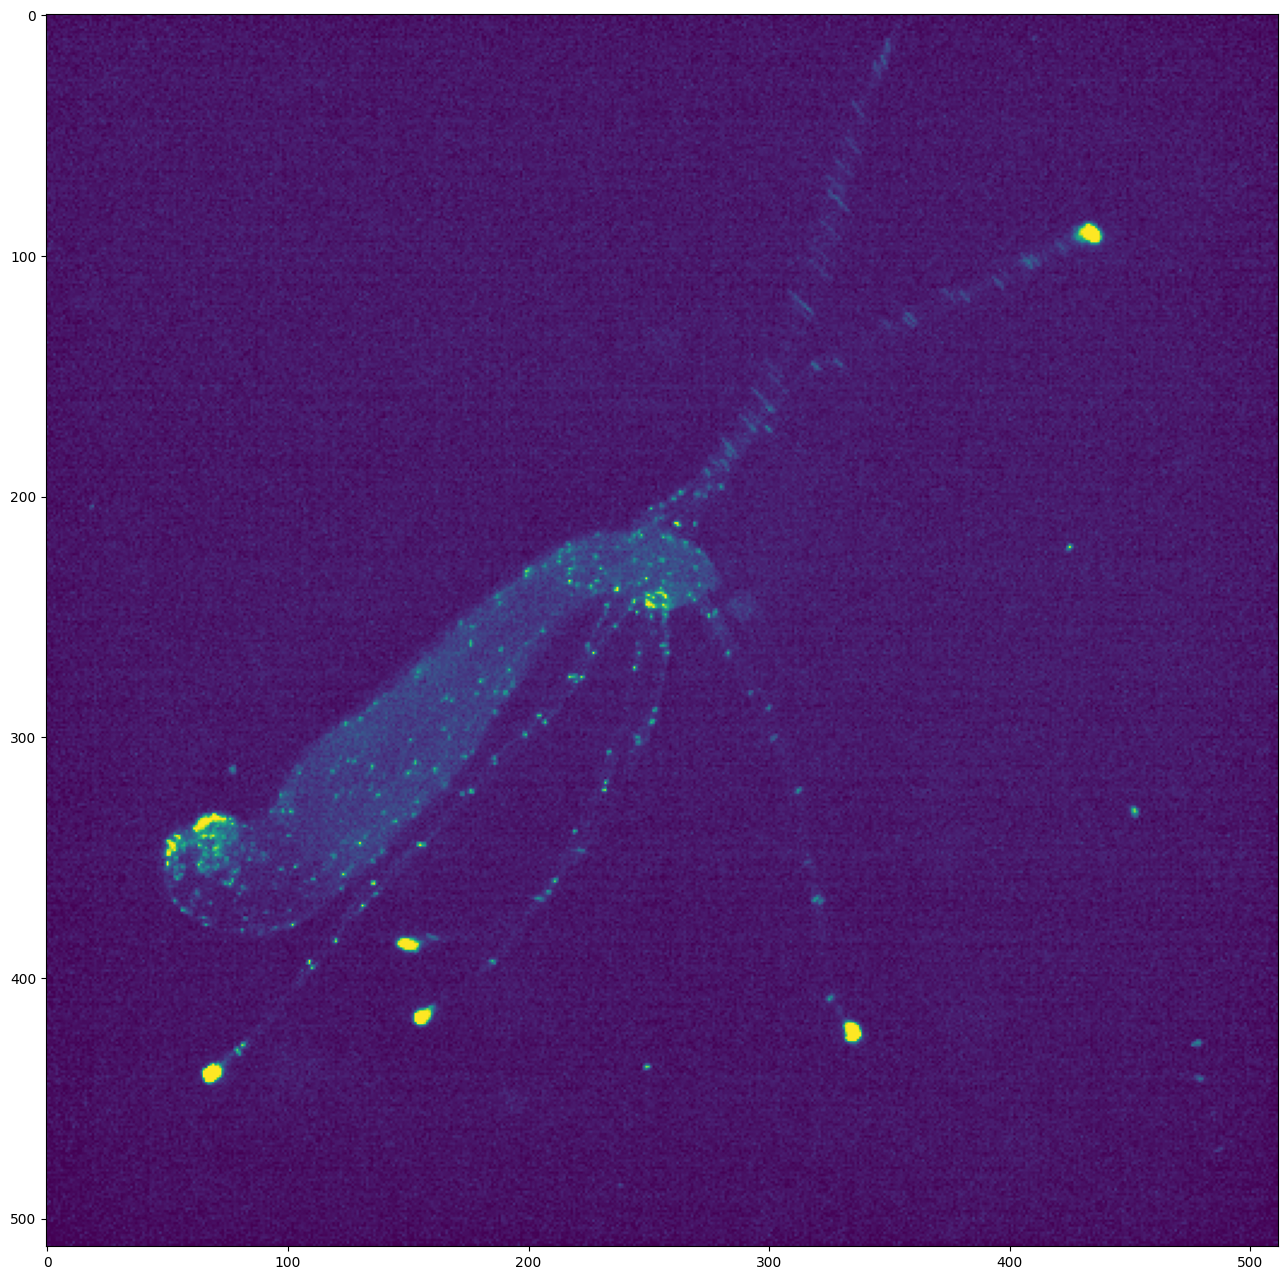

In [4]:
# Display the first frame

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(video[0])
plt.show()

In [5]:
# Visualisation of the whole video with opencv

for i, frame in enumerate(video):
    # Display the resulting frame
    cv2.imshow('Frame', frame)
    cv2.setWindowTitle('Frame', f'Frame {i} / {len(video)}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey(1000 // fps) & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break


# Closes all the frames
cv2.destroyAllWindows()

## Detections on a video: Example of SpotDetector

In [6]:
import numpy as np
import torch

from byotrack.implementation.detector.spot_detector import SpotDetector

In [7]:
# Create the detector object with its hyper parameters

detector = SpotDetector(scale=1, k=3.0, min_area=3, batch_size=20, device=torch.device("cpu"))

In [8]:
# Run the detection process on the current video

if TEST:  # Use slicing on video to run detection only on a part of it
    detections_sequence = detector.run(video[:50])
else:
    detections_sequence = detector.run(video)

Spot Detector: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.62it/s]


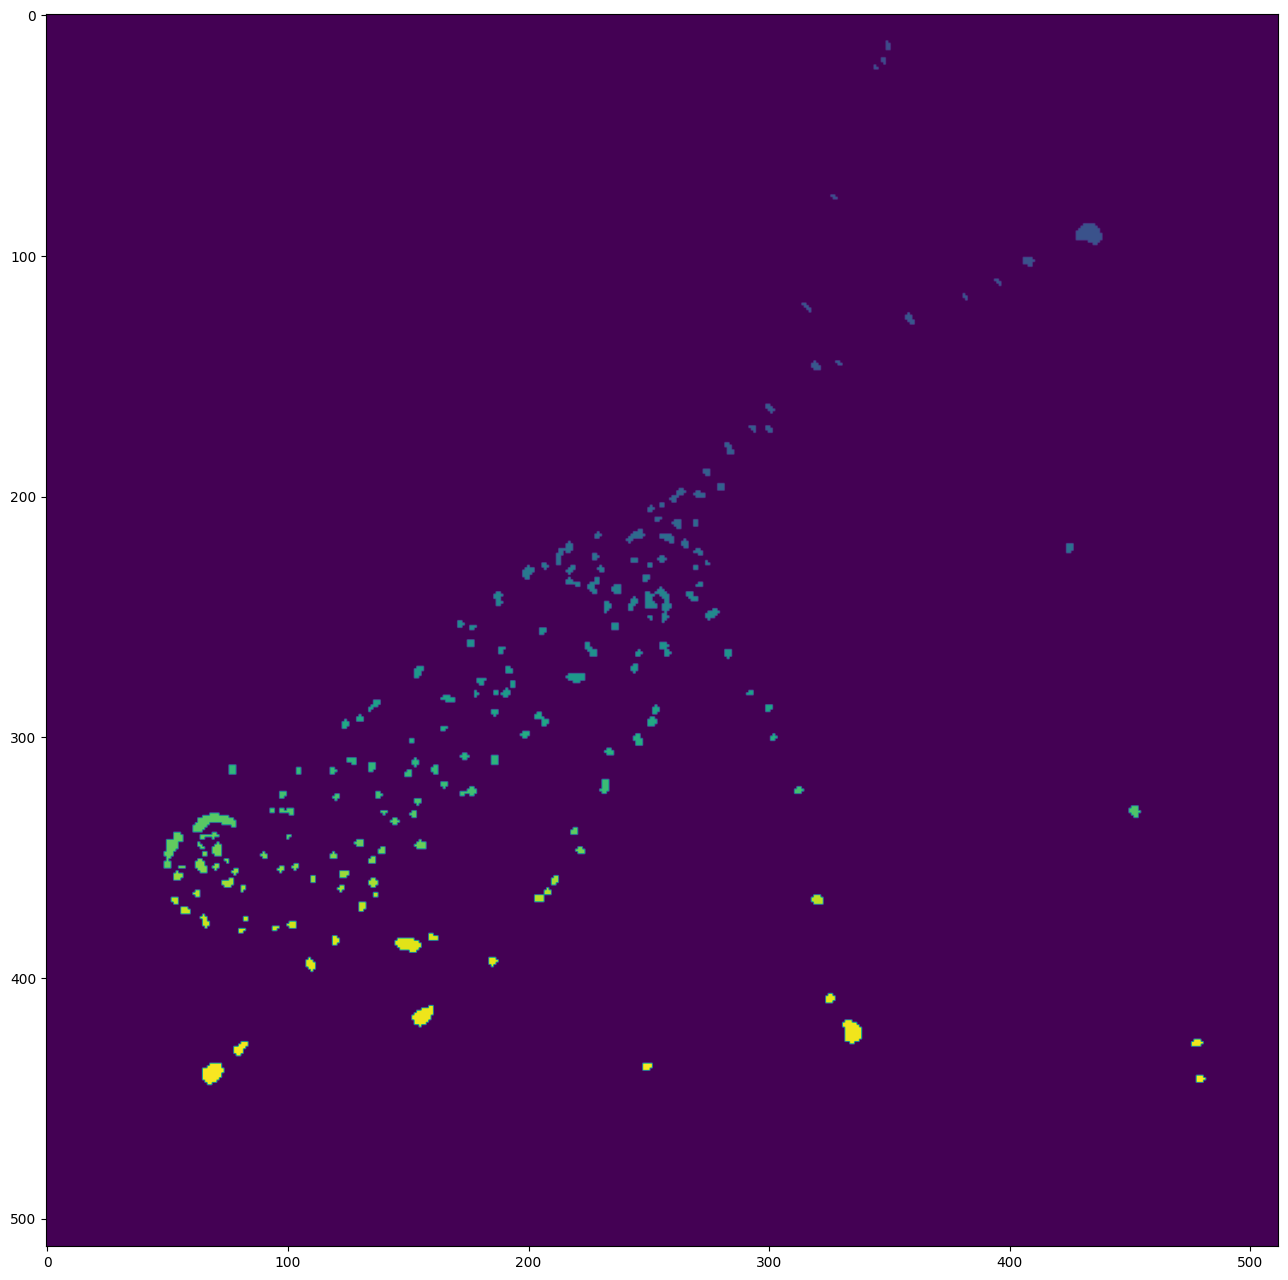

In [9]:
# Display the first detections

segmentation = detections_sequence[0].segmentation.clone()
segmentation[segmentation!=0] += 50  # Improve visibility of firsts labels

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(segmentation)
plt.show()

In [10]:
# Display the detections with opencv
# Use w and x to move backward/forward in the video

i = 0
while True:
    mask = (detections_sequence[i].segmentation.numpy() != 0).astype(np.uint8) * 255
    
    # Display the resulting frame
    cv2.imshow('Frame', mask)
    cv2.setWindowTitle('Frame', f'Frame {i} / {len(detections_sequence)} - Number of detections: {detections_sequence[i].length}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey() & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break
        
    if key == ord("w"):
        i = (i - 1) % len(detections_sequence)

    if key == ord("x"):
        i = (i + 1) % len(detections_sequence)

cv2.destroyAllWindows()

In [11]:
# Set hyperparameters manually on the video
# Use w/x to move backward/forward in the video
# Use c/v to update k (the main hyperparameter)
# You can restard with another scale/min_area

K_SPEED = 0.01

i = 0
detector = SpotDetector(scale=1, k=3.0, min_area=3, device=torch.device("cpu"))

while True:
    frame = video[i]
    detections = detector.detect(frame[None, ...])[0]
    mask = (detections.segmentation.numpy() != 0).astype(np.uint8) * 255

    # Display the resulting frame
    cv2.imshow('Frame', mask)
    cv2.setWindowTitle('Frame', f'Frame {i} / {len(video)} - k={detector.k} - Num detections: {detections.length}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey() & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break
        
    if key == ord("w"):
        i = (i - 1) % len(video)

    if key == ord("x"):
        i = (i + 1) % len(video)
        
    if key == ord("c"):
        detector.k = detector.k * (1 - K_SPEED)

    if key == ord("v"):
        detector.k = detector.k * (1 + K_SPEED)
    

cv2.destroyAllWindows()

## Link detections: Example of IcyEMHTLinker

In [12]:
from byotrack import Track
from byotrack.implementation.linker.icy_emht import IcyEMHTLinker

In [13]:
# Create the linker object with icy path
# This Linker requires to install Icy software first

linker = IcyEMHTLinker(icy_path)

In [14]:
# You can set the expected motion of particles

linker.motion = linker.Motion.BROWNIAN  # Already by default

In [15]:
# Run the linker given a video (Unused) and detections

if TEST:  # Use slicing to run linker only on a part of the data
    tracks = linker.run(video, detections_sequence[:50])
else:
    tracks = linker.run(video, detections_sequence)

Launching ICY with: java -jar icy.jar -hl -x plugins.adufour.protocols.Protocols protocol=/home/rreme/workspace/pasteur/byotrack/byotrack/implementation/linker/icy_emht/emht_protocol.xml rois=/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_rois.xml tracks=/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_tracks.xml directed=0 multi=0
Initializing...

OpenJDK Runtime Environment 11.0.19+7-post-Ubuntu-0ubuntu120.04.1 (64 bit)
Running on Linux 5.15.0-73-generic (amd64)
Number of processors : 16
System total memory : 32.7 GB
System available memory : 9.4 GB
Max java memory : 8.2 GB
Image cache initialized (reserved memory = 3189 MB, disk cache location = '/tmp/icy_cache')
Headless mode.

java.lang.UnsatisfiedLinkError: /home/rreme/workspace/pasteur/icy_build/lib/unix64/vtk/libvtkRenderingCoreJava.so: libjawt.so: cannot open shared object file: No such file or directory

Cannot load VTK library...

Icy Version 2.4.3.0 started !



Loading workflow...
Track extraction at frame 49
Exiting...EHCache disposed
Image cache shutdown..
 done


torch.Size([50, 330, 2])


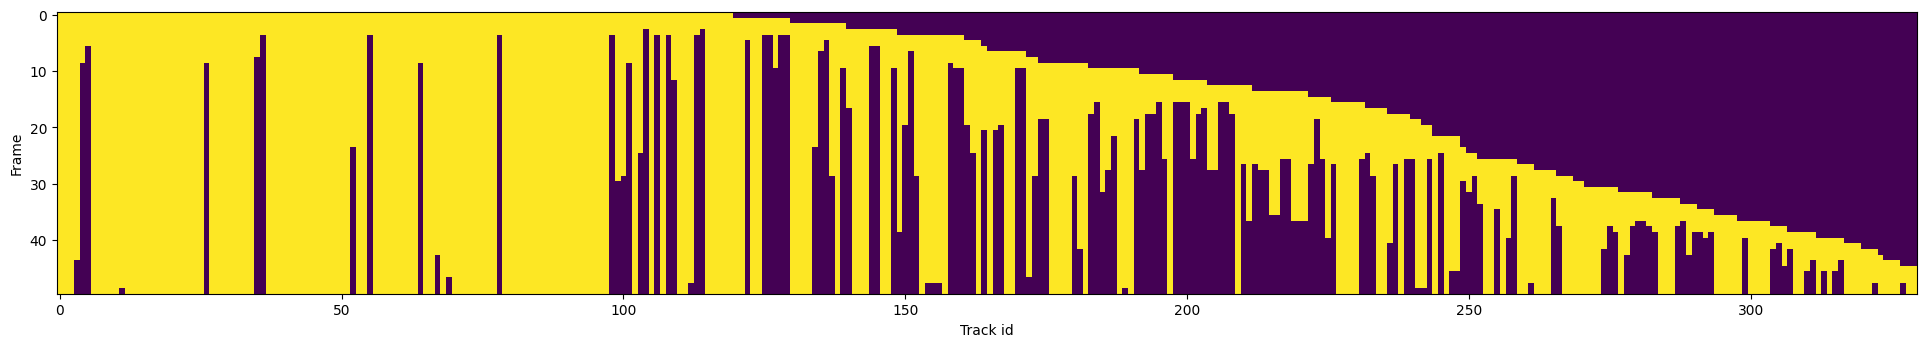

In [16]:
# Visualize tracks existence in time

# Transform into tensor
tracks_tensor = Track.tensorize(tracks)
print(tracks_tensor.shape)  # N_frame x N_track x D

mask = ~ torch.isnan(tracks_tensor).any(dim=2)

plt.figure(figsize=(24, 16), dpi=100)
plt.xlabel("Track id")
plt.ylabel("Frame")
plt.imshow(mask)
plt.show()

In [17]:
# Visualize tracks with opencv
# Use w/x to move backward/forward in the video (or space to run the video)
# Use c to display also the detections on the frame

fps = 20
running = False
display_detections = False

frame_id = 0

while True:
    frame_id += running
    frame = (video[frame_id] * 255).astype(np.uint8)
    if display_detections and frame_id < len(detections_sequence):
        mask = (detections_sequence[frame_id].segmentation.numpy() != 0).astype(np.uint8) * 255
        frame = np.concatenate((mask[..., None], frame, np.zeros_like(frame)), axis=2)
    else:
        frame = np.concatenate((np.zeros_like(frame), frame, np.zeros_like(frame)), axis=2)

    # Add tracklets
    for track in tracks:
        point = track[frame_id]
        if torch.isnan(point).any():
            continue

        x, y = point.round().to(torch.int).tolist()

        color = (0, 0, 255)  # Red

        cv2.circle(frame, (x, y), 5, color)
        cv2.putText(frame, str(track.identifier % 10), (x + 4, y - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.3, color)

    # Display the resulting frame
    cv2.imshow('Frame', frame)
    cv2.setWindowTitle('Frame', f'Frame {frame_id} / {len(video)}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey(1000 // fps) & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break

    if key == ord(" "):
        running = not running

    if not running and key == ord("w"):  # Prev
        frame_id = (frame_id - 1) % len(video)

    if not running and key == ord("x"):  # Next
        frame_id = (frame_id + 1) % len(video)
        
    if key == ord("c"):
        display_detections = 1 - display_detections

# Closes all the frames
cv2.destroyAllWindows()

## Tracks refinement: Example of Cleaner, followed by EMC2 Stitcher

In [18]:
from byotrack.implementation.refiner.cleaner import Cleaner
from byotrack.implementation.refiner.stitching import EMC2Stitcher

In [19]:
# Split tracks with consecutive dist > 3.5
# Drop tracks with length < 5

cleaner = Cleaner(min_length=5, max_dist=3.5)
tracks = cleaner.run(video, tracks)

Cleaning: Split 128 tracks and dropped 149 resulting ones
Cleaning: From 330 to 309 tracks


torch.Size([50, 309, 2])


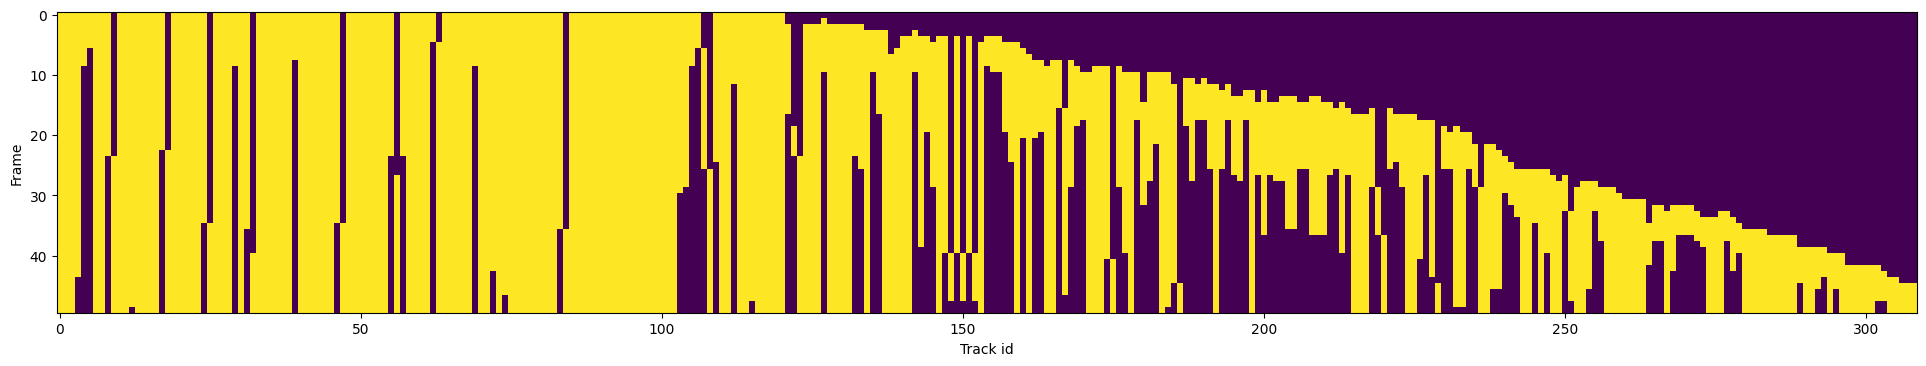

In [20]:
# Visualize tracks existence in time

# Transform into tensor
tracks_tensor = Track.tensorize(tracks)
print(tracks_tensor.shape)  # N_frame x N_track x D

mask = ~ torch.isnan(tracks_tensor).any(dim=2)

plt.figure(figsize=(24, 16), dpi=100)
plt.xlabel("Track id")
plt.ylabel("Frame")
plt.imshow(mask)
plt.show()

In [21]:
# Stitch tracks together in order to produce coherent track on all the video

stitcher = EMC2Stitcher(eta=5.0)  # Don't link tracks if they are too far (EMC dist > 5 (pixels))
tracks = stitcher.run(video, tracks)

Backward propagation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 2047.02it/s]


Merging 309 tracks into 251 resulting tracks


torch.Size([50, 251, 2])


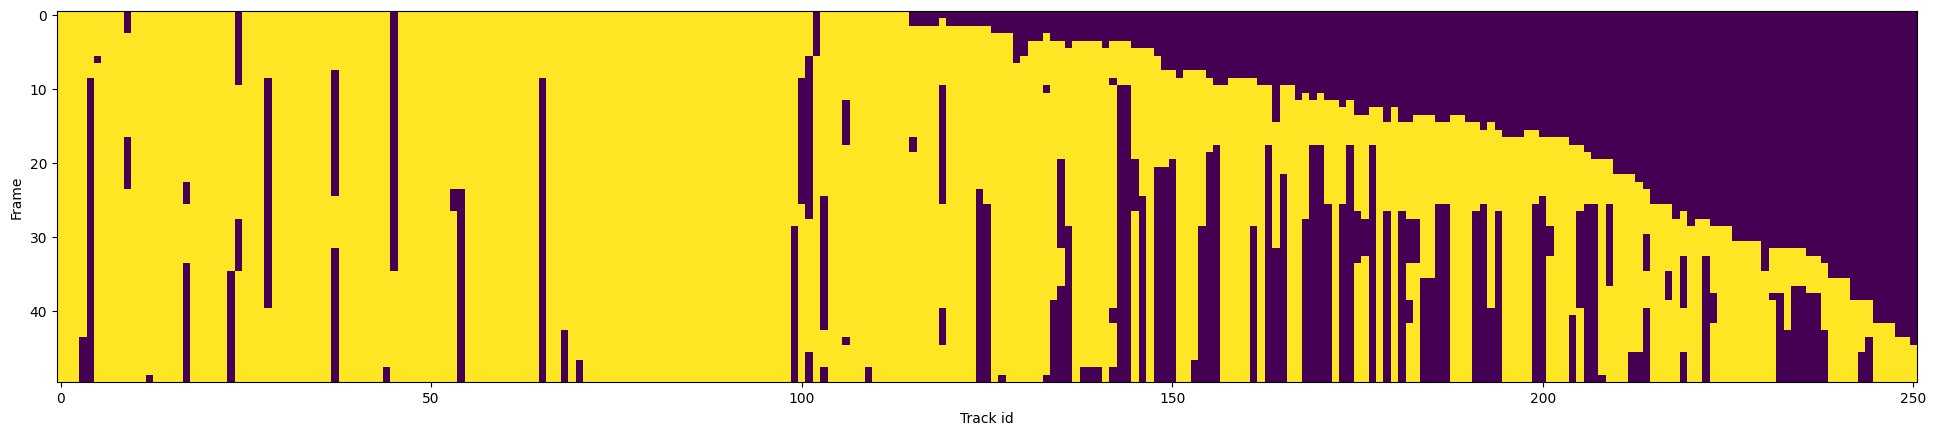

In [22]:
# Visualize tracks existence in time

# Transform into tensor
tracks_tensor = Track.tensorize(tracks)
print(tracks_tensor.shape)  # N_frame x N_track x D

mask = ~ torch.isnan(tracks_tensor).any(dim=2)

plt.figure(figsize=(24, 16), dpi=100)
plt.xlabel("Track id")
plt.ylabel("Frame")
plt.imshow(mask)
plt.show()

## End-to-end tracking: Example of MultiStepTracker

In [23]:
from byotrack import MultiStepTracker

In [24]:
# Create all the steps: Detector, Linker[, Refiner]
# Then the tracker

detector = SpotDetector(scale=1, k=3, min_area=3.0, batch_size=20, device=torch.device("cpu"))
linker = IcyEMHTLinker(icy_path)

# Optional refiner
refiners = []
if True:
    refiners = [Cleaner(5, 3.5), EMC2Stitcher(eta=5.0)]

tracker = MultiStepTracker(detector, linker, refiners)

In [25]:
if TEST:  # Use slicing on video to run tracker only on a part of it
    tracks = tracker.run(video[:50])
else:
    tracks = tracker.run(video)

Spot Detector: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.12it/s]


Launching ICY with: java -jar icy.jar -hl -x plugins.adufour.protocols.Protocols protocol=/home/rreme/workspace/pasteur/byotrack/byotrack/implementation/linker/icy_emht/emht_protocol.xml rois=/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_rois.xml tracks=/home/rreme/workspace/pasteur/byotrack/docs/source/run_examples/_tmp_tracks.xml directed=0 multi=0
Initializing...

OpenJDK Runtime Environment 11.0.19+7-post-Ubuntu-0ubuntu120.04.1 (64 bit)
Running on Linux 5.15.0-73-generic (amd64)
Number of processors : 16
System total memory : 32.7 GB
System available memory : 9.1 GB
Max java memory : 8.2 GB
Image cache initialized (reserved memory = 3189 MB, disk cache location = '/tmp/icy_cache')
Headless mode.



java.lang.UnsatisfiedLinkError: /home/rreme/workspace/pasteur/icy_build/lib/unix64/vtk/libvtkRenderingCoreJava.so: libjawt.so: cannot open shared object file: No such file or directory

Cannot load VTK library...

Icy Version 2.4.3.0 started !

Loading workflow...
Track extraction at frame 49
Exiting...EHCache disposed
Image cache shutdown..
 done
Cleaning: Split 128 tracks and dropped 149 resulting ones
Cleaning: From 330 to 309 tracks


Backward propagation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 2211.76it/s]

Merging 309 tracks into 251 resulting tracks


torch.Size([50, 251, 2])


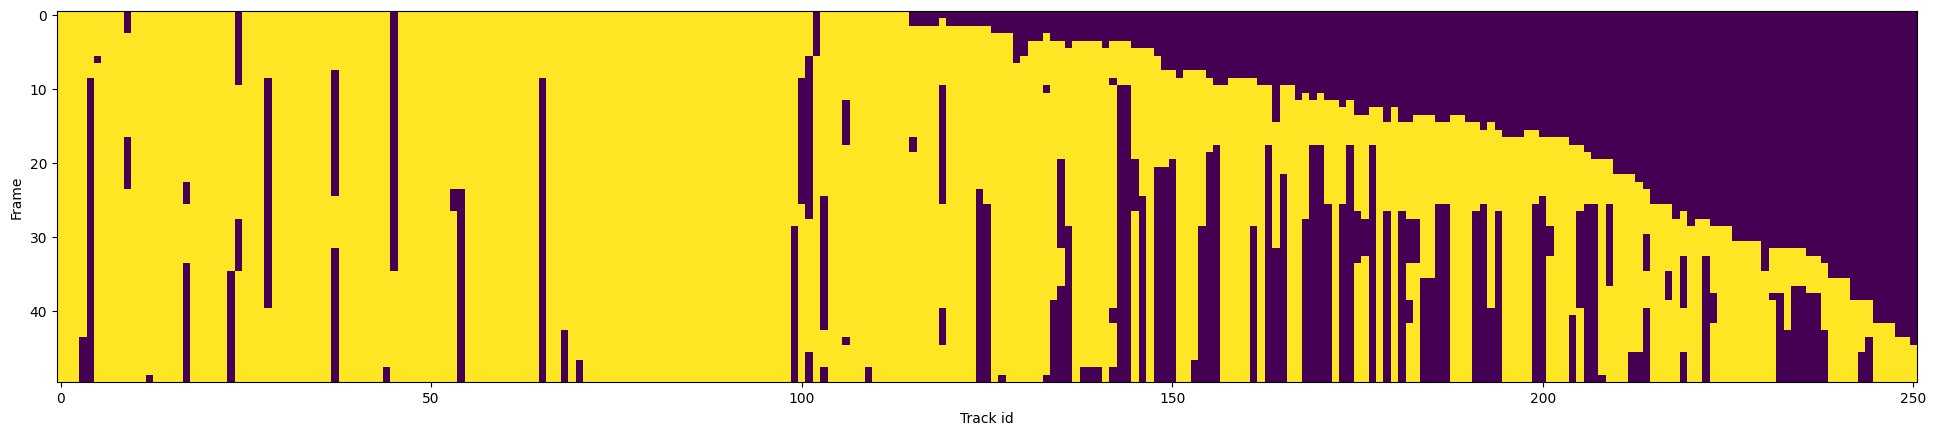

In [26]:
# Visualize tracks existence in time

# Transform into tensor
tracks_tensor = Track.tensorize(tracks)
print(tracks_tensor.shape)  # N_frame x N_track x D

mask = ~ torch.isnan(tracks_tensor).any(dim=2)

plt.figure(figsize=(24, 16), dpi=100)
plt.xlabel("Track id")
plt.ylabel("Frame")
plt.imshow(mask)
plt.show()

In [27]:
# Visualize tracks with opencv
# Use w/x to move backward/forward in the video (or space to run the video)
# Use c to display also the detections on the frame

fps = 20
running = False
display_detections = False

frame_id = 0

while True:
    frame_id += running
    frame = (video[frame_id] * 255).astype(np.uint8)
    if display_detections and frame_id < len(detections_sequence):
        mask = (detections_sequence[frame_id].segmentation.numpy() != 0).astype(np.uint8) * 255
        frame = np.concatenate((mask[..., None], frame, np.zeros_like(frame)), axis=2)
    else:
        frame = np.concatenate((np.zeros_like(frame), frame, np.zeros_like(frame)), axis=2)

    # Add tracklets
    for track in tracks:
        point = track[frame_id]
        if torch.isnan(point).any():
            continue

        x, y = point.round().to(torch.int).tolist()

        color = (0, 0, 255)  # Red

        cv2.circle(frame, (x, y), 5, color)
        cv2.putText(frame, str(track.identifier % 10), (x + 4, y - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.3, color)

    # Display the resulting frame
    cv2.imshow('Frame', frame)
    cv2.setWindowTitle('Frame', f'Frame {frame_id} / {len(video)}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey(1000 // fps) & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break

    if key == ord(" "):
        running = not running

    if not running and key == ord("w"):  # Prev
        frame_id = (frame_id - 1) % len(video)

    if not running and key == ord("x"):  # Next
        frame_id = (frame_id + 1) % len(video)
        
    if key == ord("c"):
        display_detections = 1 - display_detections

# Closes all the frames
cv2.destroyAllWindows()